# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.226240,False,-1.964265
1,0.656474,True,4.685681
2,-0.453865,True,5.925900
3,-1.091241,False,-0.722329
4,-1.070798,True,2.218160
...,...,...,...
995,-0.310067,True,4.790666
996,-1.674019,False,-0.818454
997,-2.138778,False,0.034641
998,-1.197812,False,-1.648147


<AxesSubplot: xlabel='v0'>

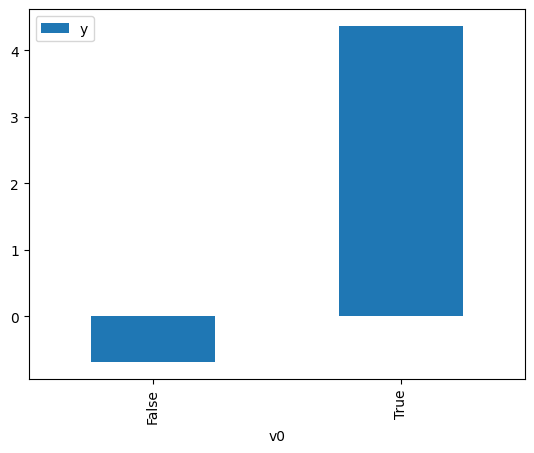

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

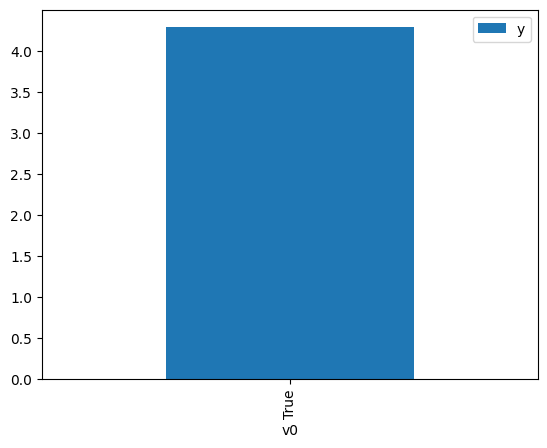

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.231688,False,-0.095881,0.902690,1.107800
1,-0.130940,False,-0.427174,0.560493,1.784144
2,-0.247098,False,1.872216,0.611248,1.635998
3,-0.453095,False,0.550333,0.695066,1.438713
4,-0.178620,False,1.660718,0.581544,1.719560
...,...,...,...,...,...
995,-2.383104,False,-2.702219,0.986654,1.013526
996,0.574757,False,-0.314727,0.263279,3.798254
997,-1.533282,False,-0.747167,0.941097,1.062589
998,-1.858220,False,-2.036891,0.966331,1.034842


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.001011,True,5.137847,0.498676,2.005310
1,-0.392952,True,3.833934,0.328387,3.045190
2,-1.720017,True,4.030889,0.042787,23.371489
3,0.050053,True,4.987136,0.520766,1.920248
4,-1.027361,True,4.081470,0.134804,7.418197
...,...,...,...,...,...
995,-2.095635,True,4.437599,0.022207,45.031777
996,-0.554172,True,3.890902,0.267739,3.734975
997,0.001011,True,5.137847,0.498676,2.005310
998,-1.427752,True,4.974694,0.070376,14.209314


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              3403.
Date:                Mon, 17 Oct 2022   Prob (F-statistic):                        0.00
Time:                        12:57:17   Log-Likelihood:                         -1465.3
No. Observations:                1000   AIC:                                      2935.
Df Residuals:                     998   BIC:                                      2944.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8642      0.026     33.436      0.000       0.813       0.915
x2             4.9202      0.065     75.663      0.000       4.793       5.048
==============================================================================
Omnibus:                        0.777   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.678   Jarque-Bera (JB):                0.662
Skew:                          -0.051   Prob(JB):                        0.718
Kurtosis:                       3.075   Cond. No.                         2.52
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""